In [66]:
%%capture
%run final_chars_classification.ipynb



In [67]:
%run table_detector.ipynb

In [68]:
%run final_functions.ipynb

In [69]:
%run preprocessing.ipynb

In [80]:
%run get_rows_number.ipynb

In [71]:
# initialize_models(True)
load_models()

In [72]:
from tabular import tabular

In [78]:
def solve_expression(img, is_table = False, showTrace = False):
    
    img = cv2.resize(img, (2448, 3264)) # size of A4
    img = img.astype(np.uint8)
    img = preprocessing(img, False)
    if showTrace:
        show_images([img])

    if(is_table):
        # show_images([table_tany(img)])
        # table_tany(img)
        cells, col_num, row_num = box_extraction(img, showTrace= showTrace)#, table= True)

        letters = [classify(i, is_letter=True) for i in cells[0:col_num]]
        numbers = [classify(i, is_0_1=True) for i in cells[col_num:]]
        
        numbers = [int(i) for i in numbers]
        
        if showTrace:
            print(letters)
            print(numbers)
            print('cols numbers ' + str(col_num))
        
        
        solver = tabular.McCluskey()
        solver.solve(numbers,col_num)
        
        solver.logic()
        

    else: 

        expression_rows = get_rows_number(img)
        
        if showTrace:
            show_images(expression_rows)
        expressions = [classify(i, is_expression=True, verbose=showTrace) for i in expression_rows ]
        
        if showTrace: print(expressions)
        return [get_table(expression) for expression in expressions]

    

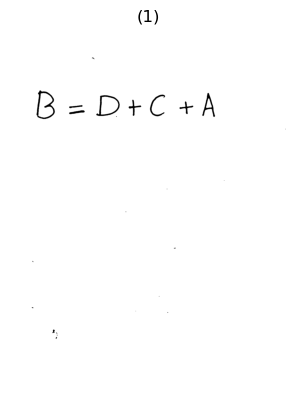

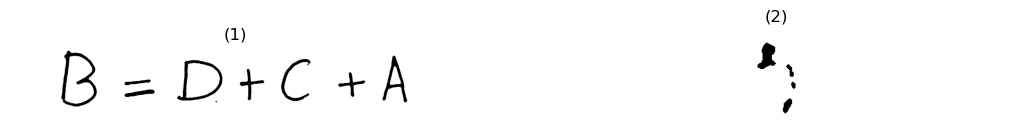

img shape: (285, 2050), max=255, min=0,median=255.0 and type uint8
tolerance: 102.5


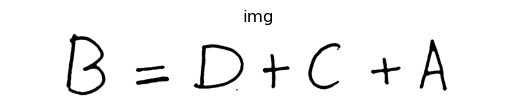

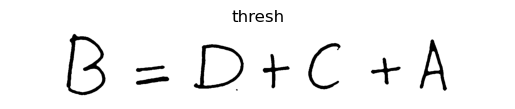

contours before area filtering
40.5, 2505.5, 1593.0, 3097.0, 3498.0, -2446.5, -18734.5, 27037.5, 4984.5, -20310.5, 8877.5, 30824.0, -581916.0, 
contours after area filtering
2505.5, 1593.0, 3097.0, 3498.0, 27037.5, 4984.5, 8877.5, 30824.0, 
masks


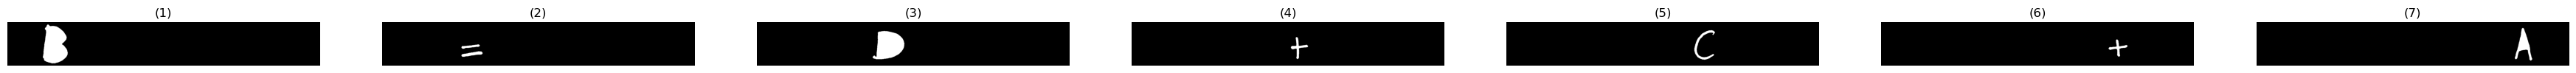

contours after merging


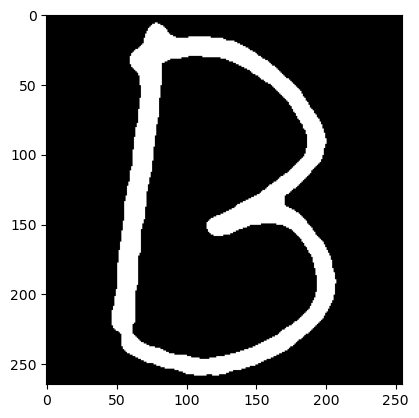

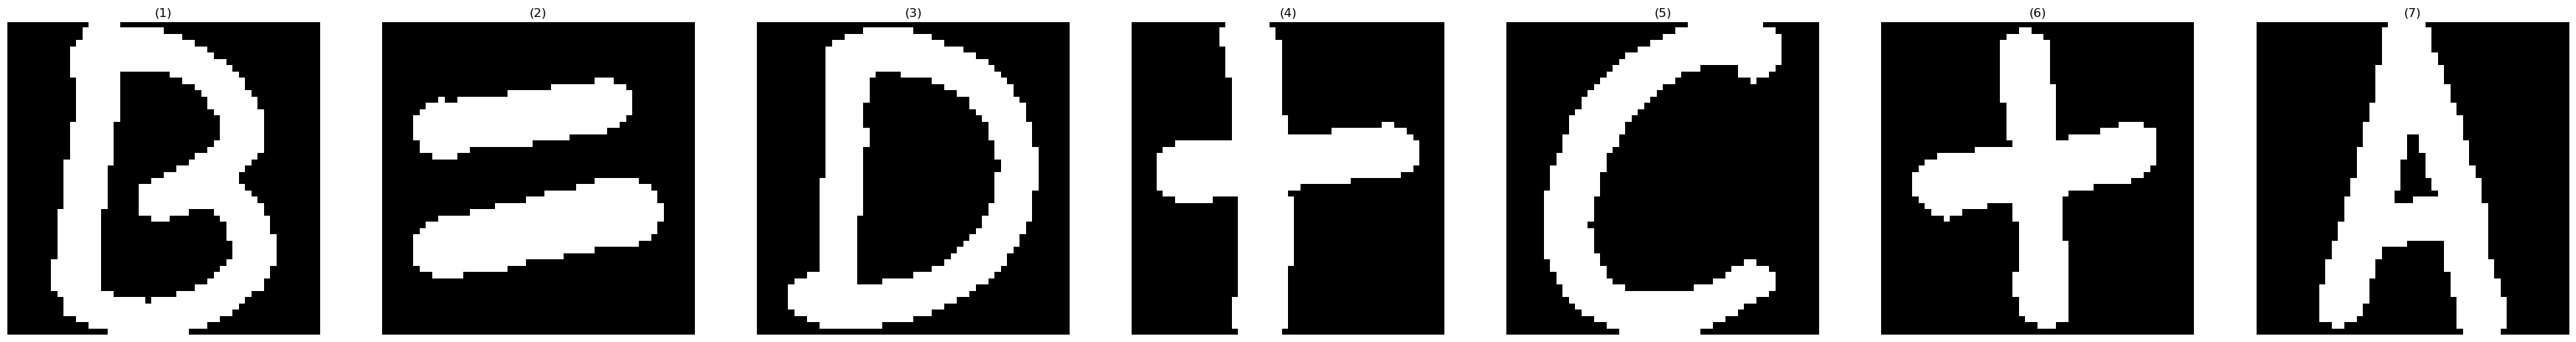

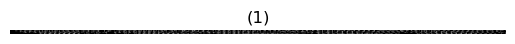

img shape: (115, 533), max=255, min=0,median=255.0 and type uint8
tolerance: 26.650000000000002


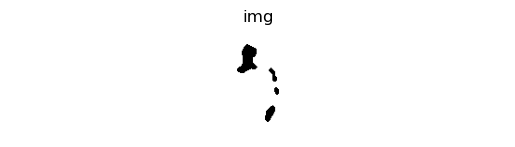

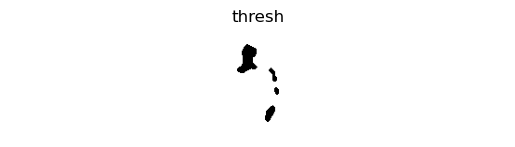

contours before area filtering
138.0, 40.0, 79.0, 436.0, -60648.0, 
contours after area filtering
138.0, 79.0, 436.0, 
masks


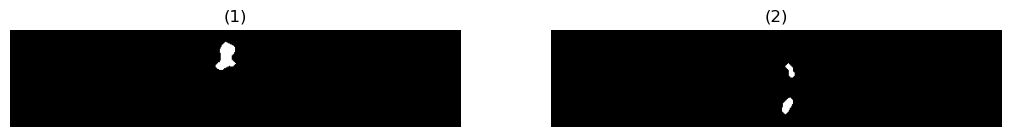

contours after merging


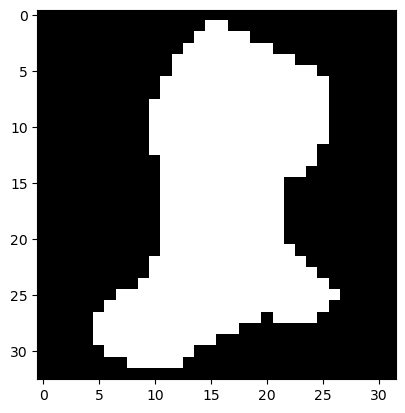

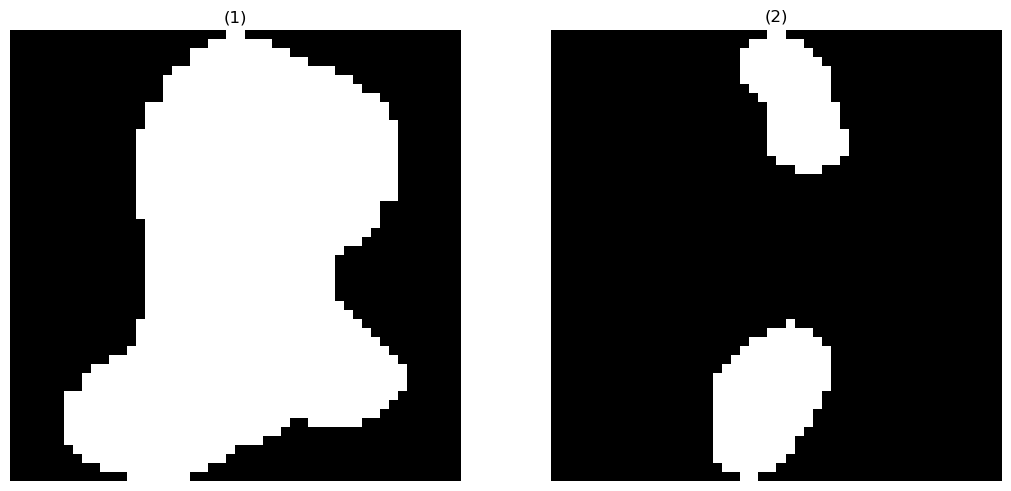

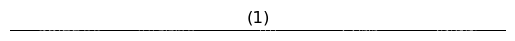

[array(['D', 'implies', 'D', '+', 'C', '+', 'A'], dtype='<U7'), array(['D', ')'], dtype='<U7')]
['D' '=' 'D' '+' 'C' '+' 'A']
D or C or A 
['D' '=']

+-----+-----+----------------+
|  A  |  C  |  D or C or A   |
|-----+-----+----------------|
|  1  |  1  |       1        |
|  1  |  0  |       1        |
|  0  |  1  |       1        |
|  0  |  0  |       0        |
+-----+-----+----------------+
None


In [84]:
image = cv2.imread("./test_images/t4.jpg")

result = solve_expression(image, is_table=False, showTrace=True)

for r in result: 
    print(r)


